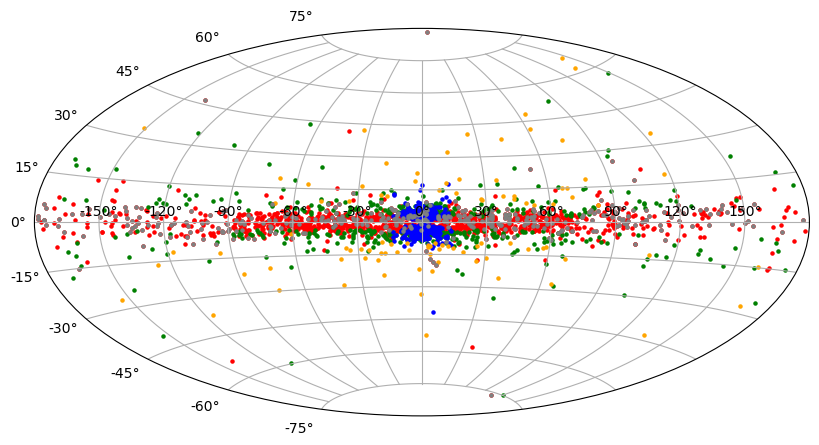

Thin Disc: 1205
Bulge: 468
Thick Disk: 463
no distance: 359
Halo: 96
no distance: 359


In [40]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
import numpy as np
import matplotlib.pyplot as plt

# Excel dosyasını yükle
file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/08122023_output.xlsx'
sheet_name = 'Sayfa10'
new_sheet_name = 'Sayfa11'

# Excel dosyasını oku
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Galactic_RA, Galactic_DEC, Disc_R ve rgeo sütunlarını al
galactic_ra = df['Glon']
galactic_dec = df['Glat']
disc_r = df['Gdist']  # Galaktik merkezden uzaklık sütunu (parsek cinsinden)
rgeo = df['rgeo']  # Kaynakların bizden uzaklıkları (parsek cinsinden)

# Galaktik koordinatları al
l = galactic_ra
b = galactic_dec

# Galaksi merkezini aitoff projeksiyonu üzerinde 0 dereceye 0 derecede konumlandırmak için
l_centered = (l - 180) % 360 - 180  # -180 ile 180 derece arasında merkezlenmiş boylam

# Harita oluştur
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection='aitoff')
ax.grid(True)

# İnce disk ve kalın disk kriterleri (galaktik yükseklik z'de)
z_ince_disk_max = 400  # parsek
z_kalin_disk_max = 1000  # parsek

ince_disk_bolge = np.abs(disc_r) <= z_ince_disk_max
kalin_disk_bolge = (np.abs(disc_r) > z_ince_disk_max) & (np.abs(disc_r) <= z_kalin_disk_max)

# İnce disk bölgesini işaretle
ax.scatter(np.radians(l_centered[ince_disk_bolge]), np.radians(b[ince_disk_bolge]), color='red', s=5)#, label='Thin Disc')

# Kalın disk bölgesini işaretle
ax.scatter(np.radians(l_centered[kalin_disk_bolge]), np.radians(b[kalin_disk_bolge]), color='green', s=5)#, label='Thick Disc')

# Galaksi merkezi ve şişkin bölge tanımı
galactic_center_distance_from_us = 8200  # parsek
galactic_bulge_radius = 2000  # parsek

# Şişkin bölge kriteri: Galaksi merkezi etrafında 2 kpc yarıçapında bir küre
siskin_bolge_bolge = (rgeo >= (galactic_center_distance_from_us - galactic_bulge_radius)) & (rgeo <= (galactic_center_distance_from_us + galactic_bulge_radius))

# Glon değeri 14 ile 346 arasında olanları şişkin bölgeden çıkartma
siskin_bolge_bolge = siskin_bolge_bolge & ~((galactic_ra > 14) & (galactic_ra < 346))

# Şişkin bölge içinde olan noktaları mavi renkte çiz
ax.scatter(np.radians(l_centered[siskin_bolge_bolge]), np.radians(b[siskin_bolge_bolge]), color='blue', s=5)#, label='Galactic Bulge')

# Halo bölgesi
halo_bolge = ~(ince_disk_bolge | kalin_disk_bolge | siskin_bolge_bolge)
ax.scatter(np.radians(l_centered[halo_bolge]), np.radians(b[halo_bolge]), color='orange', s=5)#, label='Halo')

# Diskten uzaklığı 0 olan noktaları gri renkte çiz
ax.scatter(np.radians(l_centered[np.isclose(disc_r, 0)]), np.radians(b[np.isclose(disc_r, 0)]), color='gray', s=5 )#, label='No Distance')

# Eksenleri ve başlığı ekle
#ax.set_title('Galactic Coordinate Map')
#ax.set_xlabel('Galactic Longitude (l) [degree]')
#ax.set_ylabel('Galactic Latitude (b) [degree]')

# PNG dosyasını kaydet
plt.savefig('/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/histogramlar/binleme/Aitof_project.png')
plt.show()
plt.close()

# Excel dosyasını yükle
wb = load_workbook(file_path)

# Yeni sayfa oluştur
if new_sheet_name in wb.sheetnames:
    ws = wb[new_sheet_name]
else:
    ws = wb.create_sheet(new_sheet_name)

# Gbileşen sütununu oluştur ve verileri güncelle
df['Gbileşen'] = ''
for idx in df.index:
    if np.isclose(disc_r[idx], 0):
        df.at[idx, 'Gbileşen'] = 'no distance'
    elif siskin_bolge_bolge[idx]:
        df.at[idx, 'Gbileşen'] = 'Bulge'
    elif ince_disk_bolge[idx]:
        df.at[idx, 'Gbileşen'] = 'Thin Disc'
    elif kalin_disk_bolge[idx]:
        df.at[idx, 'Gbileşen'] = 'Thick Disk'
    else:
        df.at[idx, 'Gbileşen'] = 'Halo'

# Güncellenen verileri yeni sayfaya yaz
for r in dataframe_to_rows(df, index=False, header=True):
    ws.append(r)

# Şişkin bölgeye denk gelen satırları belirle
for idx in df.index:
    row_num = idx + 2
    gbilesen = df.at[idx, 'Gbileşen']
    
    if gbilesen == 'no distance':
        fill = PatternFill(start_color='C0C0C0', end_color='C0C0C0', fill_type='solid')  # Gri
    elif gbilesen == 'Thin Disc':
        fill = PatternFill(start_color='FF0000', end_color='FF0000', fill_type='solid')  # Kırmızı
    elif gbilesen == 'Thick Disk':
        fill = PatternFill(start_color='00FF00', end_color='00FF00', fill_type='solid')  # Yeşil
    elif gbilesen == 'Bulge':
        fill = PatternFill(start_color='0000FF', end_color='0000FF', fill_type='solid')  # Mavi
    elif gbilesen == 'Halo':
        fill = PatternFill(start_color='FFA500', end_color='FFA500', fill_type='solid')  # Turuncu
    else:
        fill = None
    
    # Renklendirme işlemini ilgili hücrelere uygula
    if fill:
        for col in range(1, len(df.columns) + 1):
            ws.cell(row=row_num, column=col).fill = fill

# Değişiklikleri kaydet
wb.save(file_path)

# Gbileşen sütunundaki her bir kategorinin sayısını hesapla
gbilesen_counts = df['Gbileşen'].value_counts()

# Gbileşen sütunundaki verilerin sayısını ekrana yazdır
for gbilesen, count in gbilesen_counts.items():
    print(f"{gbilesen}: {count}")

# no distance veri sayısını ekrana yazdır
no_distance_count = (df['Gdist'] == 0).sum()
print(f"no distance: {no_distance_count}")

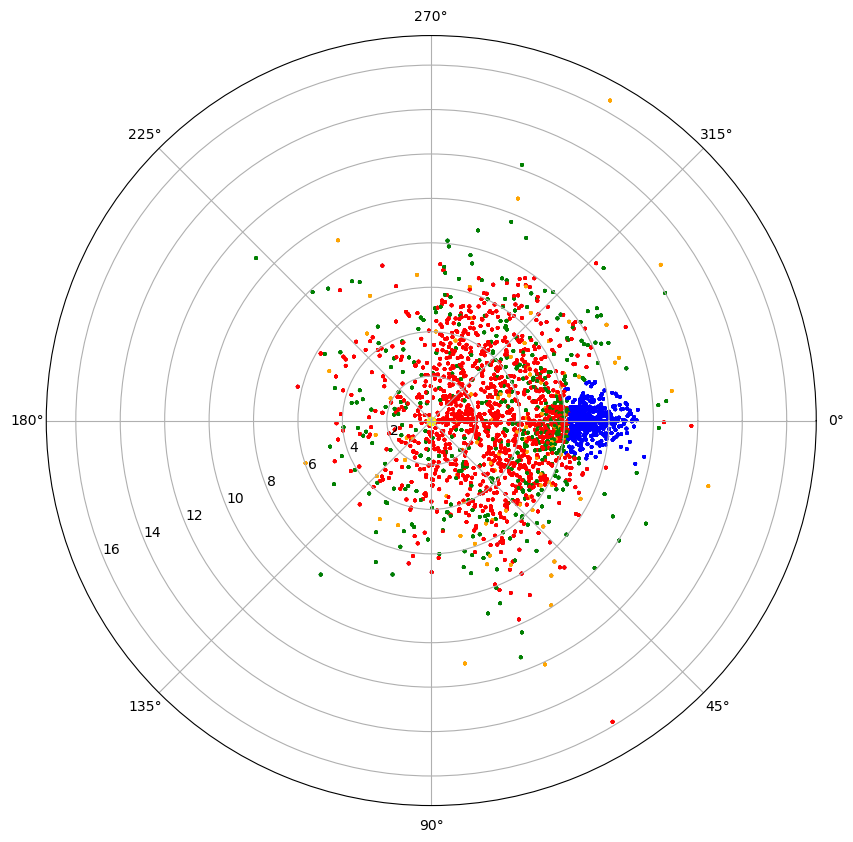

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Excel dosyasını okuma
file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/08122023_output.xlsx'
sheet_name = 'Sayfa11'

# Excel dosyasını yükleyin
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Longitude, latitude ve uzaklık verilerini alın
glon = pd.to_numeric(df['Glon'], errors='coerce')
glat = pd.to_numeric(df['Glat'], errors='coerce')
rgeo = pd.to_numeric(df['rgeo'], errors='coerce') / 1000  # parsec'leri kiloparsec'e çevirin
gbilesen = df['Gbileşen']

# Geçersiz verileri çıkarın
valid_indices = ~np.isnan(glon) & ~np.isnan(glat) & ~np.isnan(rgeo)
glon = glon[valid_indices]
glat = glat[valid_indices]
rgeo = rgeo[valid_indices]
gbilesen = gbilesen[valid_indices]

# Renk haritası oluşturma
color_map = {
    'Bulge': 'blue',
    'Thin Disc': 'red',
    'Thick Disk': 'green',
    'Halo': 'orange',
    'no distance': 'gray'
}
colors = [color_map.get(comp, 'gray') for comp in gbilesen]

# Grafik oluşturma
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 10))
ax.set_theta_zero_location('E')
ax.set_theta_direction(-1)

# H II bölgelerinin yerlerini renklendirerek gösterme
ax.scatter(np.radians(glon), rgeo, marker='.', s=10, color=colors)

# Güneş'in konumu
ax.scatter(0, 0, marker='o', color='yellow')

# Çemberler üzerindeki uzaklıkların kpc cinsinden gösterilmesi
r_ticks = np.arange(2, 18, 2)
ax.set_rticks(r_ticks)
ax.set_rlabel_position(157.5)

# Başlık ve etiketler
#ax.set_title('Spatial Distribution of PN Regions', va='bottom')

# Grafiği kaydetmek için dosya yolu oluşturma
klasor_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/histogramlar/binleme/"
dosya_adi = "PN_Regions_Spatial_Distribution.png"
kaydet_yolu = os.path.join(klasor_yolu, dosya_adi)

# Grafiği kaydet
plt.savefig(kaydet_yolu, dpi=300)

plt.show()


Bulge için bin sayıları: [  0.   0.   0.   0.   0.   0. 317. 252.  90.  21.   1.   0.   0.   0.
   0.   0.   0.]
Thin Disc için bin sayıları: [ 63. 160. 168. 206. 220. 245.  34.   0.   0.   0.   2.   1.   0.   0.
   0.   1.   0.]
Thick Disk için bin sayıları: [  6.  28.  34.  56.  78. 136.  28.   0.   0.   0.   7.   2.   1.   0.
   0.   0.   0.]
Halo için bin sayıları: [ 0.  4.  7. 12. 12. 26.  7.  0.  0.  0.  2.  1.  3.  0.  0.  0.  1.]


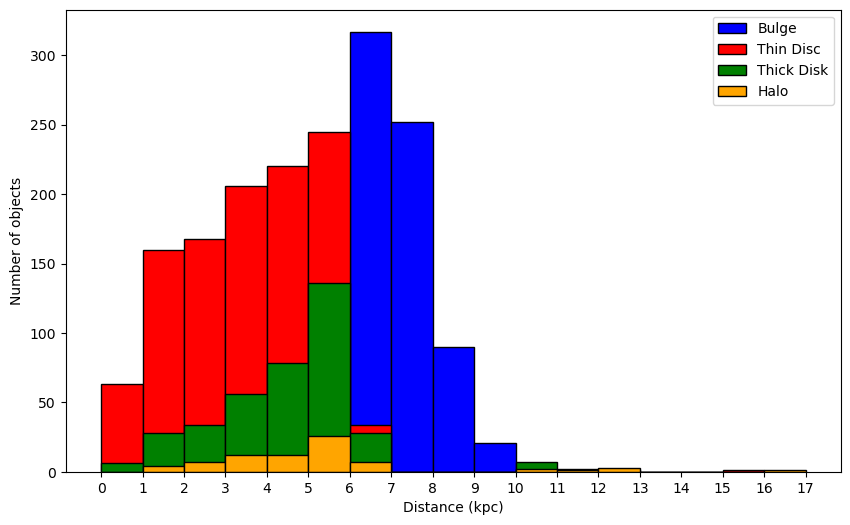

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from openpyxl import load_workbook

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/08122023_output.xlsx"
renklendirilmis_df = pd.read_excel(excel_yolu, sheet_name='Sayfa11')

# Kullanılacak sütunları seç
rgeo_sutunu = renklendirilmis_df['rgeo']
gbilesen_sutunu = renklendirilmis_df['Gbileşen']

# Verileri sayısal değerlere dönüştür
rgeo_sutunu = pd.to_numeric(rgeo_sutunu, errors='coerce')

# Verileri pc biriminden kpc birimine dönüştür
rgeo_sutunu_kpc = rgeo_sutunu / 1000

# Renklerin ve etiketlerin belirlenmesi
renk_etiketleri = {
    'Bulge': 'blue',          # Bulge ise mavi
    'Thin Disc': 'red',       # Thin Disc ise kırmızı
    'Thick Disk': 'green',    # Thick Disk ise yeşil
    'Halo': 'orange',         # Halo ise turuncu
    #'No Distance': 'gray'     # no distance ise gri
}

bins = np.arange(0, 18, 1)

# Tek bir histogram üzerinde tüm bileşenleri çiz
plt.figure(figsize=(10, 6))

for component, color in renk_etiketleri.items():
    component_values = rgeo_sutunu_kpc[gbilesen_sutunu == component]
    counts, bins, patches = plt.hist(component_values, bins=bins, label=component, color=color, edgecolor='black')
    print(f"{component} için bin sayıları: {counts}")

plt.xticks(bins)
plt.xlabel('Distance (kpc)')
plt.ylabel('Number of objects')
plt.legend(title='')

# Grafik dosyası yolunu belirle
save_path = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/histogramlar/binleme/Distance.png"
plt.savefig(save_path)

# Grafiği göster
plt.show()

In [2]:
######## NEAT ÇIKTILARINI HİSTOGRAM OLUŞTURMA ##############

import pandas as pd
import matplotlib.pyplot as plt
import os

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/08122023_output.xlsx"
neat_result_df = pd.read_excel(excel_yolu, sheet_name='neat_result')
renklendirilmis_df = pd.read_excel(excel_yolu, sheet_name='Sayfa11')

# Histogramlar için klasör oluştur
klasor_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/histogramlar/nodistance/"
if not os.path.exists(klasor_yolu):
    os.makedirs(klasor_yolu)

# Ortalamalar için dosya oluştur
ortalama_dosyasi_yolu = os.path.join(klasor_yolu, "ortalama_degerler.txt")

# Renklendirme fonksiyonu
def get_color(component):
    if component == 'Bulge':
        return 'blue'
    elif component == 'Thin Disc':
        return 'red'
    elif component == 'Thick Disk':
        return 'green'
    elif component == 'Halo':
        return 'orange'
    #elif component == 'no distance':
        #return 'gray'
    else:
        return None

# Renklendirme bilgilerini ekle
renklendirilmis_df['color'] = renklendirilmis_df['Gbileşen'].apply(get_color)
renk_dict = renklendirilmis_df.set_index('idPNMain')['color'].to_dict()

# Sütun başlıkları
sutun_basliklari = ['c(Hb) (Ha/Hb)', 'c(Hb) (Hg/Hb)', 'c(Hb) (Hd/Hb)', '[OII] density', '[SII] Density', ' [ArIV] density', 
                    ' [OII] temperature', ' [SII] temperature', ' [NII] temperature', 
                    ' [OI] temperature', '[OIII] Temperature', ' [NeIII] temperature', 
                    ' [ArIII] temperature', ' [ArV] temperature', ' He I temperature (7281/6678)', 
                    'C/H', 'N/H', 'O/H', 'Ne/H', 'Ar/H', 'S/H', 'Cl/H', 'He/H']

# Histogram parametreleri
histogram_parametreleri = {
    'c(Hb) (Ha/Hb)': {'bins': 50, 'range': (0, 6)},
    'c(Hb) (Hg/Hb)': {'bins': 50, 'range': (0, 6)},
    'c(Hb) (Hd/Hb)': {'bins': 50, 'range': (0, 6)},
    '[OII] density': {'bins': 50, 'range': (0, 20000)},
    '[SII] Density': {'bins': 50, 'range': (0, 15000)},
    ' [ArIV] density': {'bins': 50, 'range': (0, 70000)},
    ' [OII] temperature': {'bins': 50, 'range': (5000, 35000)},
    ' [SII] temperature': {'bins': 50, 'range': (0, 35000)},
    ' [NII] temperature': {'bins': 100, 'range': (5000, 35000)},
    ' [OI] temperature': {'bins': 50, 'range': (0, 35000)},
    '[OIII] Temperature': {'bins': 50, 'range': (5000, 35000)},
    ' [NeIII] temperature': {'bins': 50, 'range': (0, 35000)},
    ' [ArIII] temperature': {'bins': 50, 'range': (5000, 35000)},
    ' [ArV] temperature': {'bins': 50, 'range': (0, 35000)},
    ' He I temperature (7281/6678)': {'bins': 50, 'range': (0, 4e5)},
    'C/H': {'bins': 50, 'range': (0, 1e-3)},
    'N/H': {'bins': 50, 'range': (0, 1e-3)},
    'O/H': {'bins': 50, 'range': (0, 3e-3)},
    'Ne/H': {'bins': 50, 'range': (0, 3e-3)},
    'Ar/H': {'bins': 50, 'range': (0, 175e-7)},
    'S/H': {'bins': 50, 'range': (0, 3e-5)},
    'Cl/H': {'bins': 50, 'range': (0, 0.6e-5)},
    'He/H': {'bins': 50, 'range': (0, 0.5)}
}

# Renklere karşılık gelen etiketler
renk_etiketleri = {
    'red': 'Thin Disc',
    'green': 'Thick Disc',
    'blue': 'Bulge',
    'orange': 'Halo'#,
    #'gray': 'No Distance'
}

# Ortalamaları yazmak için dosyayı aç
with open(ortalama_dosyasi_yolu, 'w') as f:
    # Her sütun için histogram oluştur
    for baslik in sutun_basliklari:
        plt.figure()
        bins = histogram_parametreleri[baslik]['bins']
        range_ = histogram_parametreleri[baslik]['range']
        ortalamalar = {}
        
        for color, etiket in renk_etiketleri.items():
            filtreli_veri = neat_result_df[neat_result_df['idPNMain'].map(renk_dict) == color][baslik]
            filtreli_veri = filtreli_veri[(filtreli_veri != 0) & (filtreli_veri != 35000)]
            
            if not filtreli_veri.empty:
                plt.hist(filtreli_veri, bins=bins, range=range_, edgecolor='black', color=color, label=etiket)
                ortalama = filtreli_veri.mean()
                ortalamalar[etiket] = ortalama
        
        # Ortalama değerleri kesikli çizgilerle göster
        for etiket, ortalama in ortalamalar.items():
            # Ortalama değeri dosyaya bilimsel gösterimle yaz
            f.write(f"{baslik} - {etiket} Ortalama: {ortalama:.2e}\n")
            # Eğer ortalama belirlenen aralıktaysa histogramda göster
            if range_[0] <= ortalama <= range_[1]:
                color = [k for k, v in renk_etiketleri.items() if v == etiket][0]
                plt.axvline(ortalama, color=color, linestyle='dashed', linewidth=1)
        
        # Plot ayarları
        plt.title(baslik)
        plt.xlabel("Değer")
        plt.ylabel("Frekans")
        plt.legend()
        
        # Histogramı kaydet
        kaydet_yolu = os.path.join(klasor_yolu, f"{baslik.replace('/', '_')}.png")
        plt.savefig(kaydet_yolu, dpi=300)
        
        # Plot'u temizle
        plt.clf()

print("Histogramlar başarıyla oluşturuldu ve ortalamalar listeye yazıldı.")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/ry/6rcrw5vs4f33lx3wyt4f6m5w0000gn/T/ipykernel_2038/421326337.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are r

Histogramlar başarıyla oluşturuldu ve ortalamalar listeye yazıldı.


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
####### NEAT SONUÇLARINDA ORTALAMALARI TABLOLAŞTIRMA ##########


import os

# Ortalamalar dosyasını oku
ortalama_dosyasi_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/histogramlar/ortalama_degerler.txt"
with open(ortalama_dosyasi_yolu, 'r') as f:
    ortalama_veriler = f.readlines()

# Ortalamaları bir sözlükte sakla
ortalama_dict = {}
bilesenler = set()
for veri in ortalama_veriler:
    veri = veri.strip()
    baslik, kalan = veri.split(' - ')
    bilesen, ortalama = kalan.split(' Ortalama: ')
    if baslik not in ortalama_dict:
        ortalama_dict[baslik] = {}
    ortalama_dict[baslik][bilesen] = ortalama
    bilesenler.add(bilesen)

# LaTeX formatında tabloyu oluştur
latex_tablo = """
\\begin{table}[H]
\\centering
\\begin{tabular}{|c|""" + 'c|' * len(bilesenler) + """}
\\hline
Sütun Başlığı & """ + ' & '.join(bilesenler) + """ \\\\
\\hline
"""

for baslik, bilesen_dict in ortalama_dict.items():
    row = baslik
    for bilesen in bilesenler:
        row += ' & ' + bilesen_dict.get(bilesen, '')
    latex_tablo += row + " \\\\\n\\hline\n"

latex_tablo += """
\\end{tabular}
\\caption{Ortalama Değerler}
\\label{tab:ortalama_degerler}
\\end{table}
"""

# LaTeX tabloyu dosyaya yaz
latex_tablo_dosyasi_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/histogramlar/ortalama_degerler_tablo.tex"
with open(latex_tablo_dosyasi_yolu, 'w') as f:
    f.write(latex_tablo)

print("LaTeX tablosu başarıyla oluşturuldu ve kaydedildi.")


LaTeX tablosu başarıyla oluşturuldu ve kaydedildi.


In [ ]:
##### HDUL OKUMA ######

import numpy as np
from astropy.io import fits

# Specify the path to your FITS file
fits_file_path = '/Users/nurullah/Desktop/true_PNe/sn/sn/png021.3+02.2.txt_lines1.fits'
# Open the FITS file
with fits.open(fits_file_path) as hdul:
    # Access the data in the FITS file
    primary_hdu = hdul[3]
    data = primary_hdu.data
    
with fits.open(fits_file_path) as hdul:
    hdul.info()

    # Print the transposed data
    print("")
    print(data)

In [5]:
from astropy.io import fits

# Specify the path to your FITS file
#fits_file_path = '/Users/nurullah/Desktop/true_PNe/dalgaboyudüzenlendi/alfa_girdi/neat_girdi/neat_out/png080.2+03.8.fits_lines.fits'
fits_file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/neat_out/6dF_Aug2003_ESO393-32_6D210803_id1212.fits_lines.fits'

# Open the FITS file
with fits.open(fits_file_path) as hdul:
    # You can access the data in the FITS file
    # For example, printing the information about the FITS file:
    hdul.info()
    
    # You can access different HDU (Header Data Unit) in the FITS file
    # For example, to access the primary HDU (usually the first one):
    primary_hdu = hdul[2]

    # You can access the data and header of the primary HDU
    data = primary_hdu.data
    header = primary_hdu.header

    # You can also print the header and data to see the details
    print("Header:")
    print(repr(header))
    print("Data:")
    print(data)

Filename: /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/neat_out/6dF_Aug2003_ESO393-32_6D210803_id1212.fits_lines.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  LINES         1 BinTableHDU     51   36R x 18C   [1E, 1E, 1E, 1E, 1E, 1E, 16A, 16A, 16A, 16A, 1I, 1I, 1E, 1E, 1E, 1E, 1E, 1E]   
  2  RESULTS       1 BinTableHDU     21   166R x 4C   [40A, 1E, 1E, 1E]   
  3  QC            1 BinTableHDU     13   1R x 2C   [1L, 1L]   
Header:
XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   52 / width of table in bytes                        
NAXIS2  =                  166 / number of rows in table                        
PCOUNT  =                    0 / size of special data area   

In [51]:
#### GDPNE klasöründe bulunan alt klasörlerdeki fits dosyalarını tek bir klasöre kaydetme ###



import os
import shutil

def klasorleri_birlestir(ana_klasor, hedef_klasor):
    if not os.path.exists(hedef_klasor):
        os.makedirs(hedef_klasor)

    for root, dirs, files in os.walk(ana_klasor):
        for file in files:
            if file.endswith('.fits'):
                dosya_yolu = os.path.join(root, file)
                shutil.copy2(dosya_yolu, hedef_klasor)

    print(f'Tüm .fits dosyaları {hedef_klasor} klasörüne kopyalandı.')

if __name__ == "__main__":
    ana_klasor = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/GPNE/00008//"  # Ana klasörünüzün yolunu belirtin
    cikti_dosyasi = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/id8/"  # Çıktı dosyasının adını ve yolunu belirtin

    klasorleri_birlestir(ana_klasor, cikti_dosyasi)

Tüm .fits dosyaları /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/id8/ klasörüne kopyalandı.


In [ ]:
from astropy.io import fits
import pandas as pd
import os

# Dizin içindeki tüm FITS dosyalarını al
fits_directory = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/neat_out/'
fits_file_paths = [os.path.join(fits_directory, file) for file in sorted(os.listdir(fits_directory)) if file.endswith('.fits')]

# Excel dosyalarının kaydedileceği dizin
output_directory = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/'
os.makedirs(output_directory, exist_ok=True)

# Her 50 FITS dosyası için ayrı bir Excel dosyası oluştur
batch_size = 50

# Dosya isimlerini saklayacak bir sözlük oluştur
file_names_dict = {}

for i in range(0, len(fits_file_paths), batch_size):
    batch_fits_files = fits_file_paths[i:i + batch_size]

    # Excel dosyasının ismini belirle
    excel_file_name = f'batch_{i // batch_size + 1}.xlsx'
    excel_file_path = os.path.join(output_directory, excel_file_name)

    # Her FITS dosyası için döngü
    with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
        for fits_file_path in batch_fits_files:
            # Open the FITS file
            with fits.open(fits_file_path) as hdul:
                # Access the data and header of the LINES BinTableHDU (hdul[2])
                data = hdul[1].data

                # Convert the FITS data to a pandas DataFrame
                df = pd.DataFrame(data)

                # Sadece belirtilen sütunları seç
                selected_columns = ['WlenRest', 'Flux', 'Uncertainty', 'Ion', 'DereddenedFlux', 'DereddenedFluxLo', 'DereddenedFluxHi']
                df_selected = df[selected_columns]

                # Negatif ve sıfıra eşit olan değerlere sahip satırları filtrele ve sil
                df_selected = df_selected[df_selected['Flux'] > 0.01]

                # Sayfa adını dosya isminin ilk 31 karakteri olarak ayarla
                sheet_name = os.path.basename(fits_file_path)[:31]
                
                # Tam dosya ismini sözlüğe ekle
                file_names_dict[sheet_name] = os.path.basename(fits_file_path)

                # Verileri içeren DataFrame'i yeni bir sayfada kaydet
                df_selected.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"Data has been successfully exported to {excel_file_path}")

# Dosya isimlerini bir CSV dosyasına kaydedelim
file_names_dict_path = os.path.join(output_directory, 'file_names_dict.csv')
file_names_df = pd.DataFrame(list(file_names_dict.items()), columns=['SheetName', 'FullFileName'])
file_names_df.to_csv(file_names_dict_path, index=False)


In [ ]:
import pandas as pd
import os

# Excel dosyalarının bulunduğu klasörün tam yolu
excel_folder_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/'

# Tüm Excel dosyalarını al
excel_files = [os.path.join(excel_folder_path, file) for file in sorted(os.listdir(excel_folder_path)) if file.endswith('.xlsx')]

# Dosya isimleri sözlüğünü oku
file_names_dict_path = os.path.join(excel_folder_path, 'file_names_dict.csv')
file_names_df = pd.read_csv(file_names_dict_path)
file_names_dict = dict(zip(file_names_df['SheetName'], file_names_df['FullFileName']))

# Birleştirilecek verileri tutacak ana DataFrame'i oluştur
main_df = pd.DataFrame()

# Her Excel dosyası için döngü
for excel_file_path in excel_files:
    # Excel dosyasını oku
    df = pd.read_excel(excel_file_path, sheet_name=None)

    # Her sayfa için döngü
    for sheet_name, sheet_data in df.items():
        # 'WlenRest', 'Ion', 'Flux' sütunlarını içeren sayfaları seç
        if all(col in sheet_data.columns for col in ['WlenRest', 'Ion', 'Flux']):
            full_file_name = file_names_dict.get(sheet_name, sheet_name)
            # Eğer ana DataFrame boşsa, direkt ekle
            if main_df.empty:
                main_df = sheet_data[['WlenRest', 'Ion', 'Flux']].copy()
                main_df.rename(columns={'Flux': f'Flux_{full_file_name}'}, inplace=True)
            else:
                # Ana DataFrame'de 'WlenRest' ve 'Ion' sütunlarına göre birleştirme yap
                main_df = main_df.merge(sheet_data[['WlenRest', 'Ion', 'Flux']],
                                        on=['WlenRest', 'Ion'],
                                        how='outer',
                                        suffixes=('', f'_{full_file_name}'))

# NaN değerleri '-' ile değiştir
main_df.fillna('-', inplace=True)

# 'WlenRest' sütununa göre küçükten büyüğe sırala
main_df.sort_values('WlenRest', inplace=True)

# Excel dosyasına ekleyeceğimiz sayfa adı
new_sheet_name = 'Flux_Tablo'

# Yeni bir Excel dosyası oluştur
output_excel_file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/Fluxtablo.xlsx'
with pd.ExcelWriter(output_excel_file_path, engine='openpyxl') as writer:
    main_df.to_excel(writer, sheet_name=new_sheet_name, index=False)

print(f"Merged, sorted data has been successfully added to the sheet {new_sheet_name} in the Excel file.")


In [ ]:
import pandas as pd
import os

# Excel dosyalarının bulunduğu klasörün tam yolu
excel_folder_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/'

# Tüm Excel dosyalarını al
excel_files = [os.path.join(excel_folder_path, file) for file in sorted(os.listdir(excel_folder_path)) if file.endswith('.xlsx')]

# Dosya isimleri sözlüğünü oku
file_names_dict_path = os.path.join(excel_folder_path, 'file_names_dict.csv')
file_names_df = pd.read_csv(file_names_dict_path)
file_names_dict = dict(zip(file_names_df['SheetName'], file_names_df['FullFileName']))

# Birleştirilecek verileri tutacak ana DataFrame'i oluştur
main_df = pd.DataFrame()

# Her Excel dosyası için döngü
for excel_file_path in excel_files:
    # Excel dosyasını oku
    df = pd.read_excel(excel_file_path, sheet_name=None)

    # Her sayfa için döngü
    for sheet_name, sheet_data in df.items():
        # 'WlenRest', 'Ion', 'DereddenedFlux' sütunlarını içeren sayfaları seç
        if all(col in sheet_data.columns for col in ['WlenRest', 'Ion', 'DereddenedFlux']):
            full_file_name = file_names_dict.get(sheet_name, sheet_name)
            # Eğer ana DataFrame boşsa, direkt ekle
            if main_df.empty:
                main_df = sheet_data[['WlenRest', 'Ion', 'DereddenedFlux']].copy()
                main_df.rename(columns={'DereddenedFlux': f'DereddenedFlux_{full_file_name}'}, inplace=True)
            else:
                # Ana DataFrame'de 'WlenRest' ve 'Ion' sütunlarına göre birleştirme yap
                main_df = main_df.merge(sheet_data[['WlenRest', 'Ion', 'DereddenedFlux']],
                                        on=['WlenRest', 'Ion'],
                                        how='outer',
                                        suffixes=('', f'_{full_file_name}'))

# NaN değerleri '-' ile değiştir
main_df.fillna('-', inplace=True)

# 'WlenRest' sütununa göre küçükten büyüğe sırala
main_df.sort_values('WlenRest', inplace=True)

# Excel dosyasına ekleyeceğimiz sayfa adı
new_sheet_name = 'DereddenedFlux_Tablo'

# Yeni bir Excel dosyası oluştur
output_excel_file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/DereddebFluxtablo.xlsx'
with pd.ExcelWriter(output_excel_file_path, engine='openpyxl') as writer:
    main_df.to_excel(writer, sheet_name=new_sheet_name, index=False)

print(f"Merged, sorted data has been successfully added to the sheet {new_sheet_name} in the Excel file.")


In [7]:
import os
import pandas as pd
from astropy.io import fits

# Klasördeki tüm FITS dosyalarını al
fits_folder_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/neat_out/'
fits_files = [file for file in os.listdir(fits_folder_path) if file.endswith('.fits')]

# Boş bir DataFrame oluştur
final_data = pd.DataFrame()

# Her bir FITS dosyasını işle
for fits_file in fits_files:
    fits_path = os.path.join(fits_folder_path, fits_file)

    with fits.open(fits_path) as hdul:
        # İlgili HDU'ya eriş
        results_hdu = hdul['RESULTS']
        
        # İlgilenilen sütunu seç (2. sütun, Python'da indeks 1'e denk gelir)
        selected_data = results_hdu.data.field(1)
        
        # Pandas Series'e dönüştür
        fits_data = pd.Series(selected_data, name=fits_file)
        
        # DataFrame'e ekle
        final_data = pd.concat([final_data, fits_data], axis=1)

# Verileri Excel dosyasına yaz
excel_output_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/neat_out_hdul3.xlsx'
final_data.to_excel(excel_output_path, index=False)

print(f"Data from FITS files has been successfully saved to {excel_output_path}.")

Data from FITS files has been successfully saved to /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/neat_out_hdul3.xlsx.


In [4]:
################# idPNMain ve fits_name verilerinden smb_bpt verilerini bileşenlerini belirleme ##########

#### excelde düşeyara ile bu işlemleri yaopabiliriz.



import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# Excel dosyasını oku
file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/Sigma_5.xlsx'
xls = pd.ExcelFile(file_path)

# Sayfa2 ve Sayfa3 verilerini al
sayfa2_df = pd.read_excel(xls, 'Sayfa1')
sayfa3_df = pd.read_excel(xls, 'smb_bpt')

# Sayfa2'deki Fits_Name sütunundaki verilerin sonundaki boşlukları kaldır
sayfa2_df['Fits_Name'] = sayfa2_df['Fits_Name'].str.strip()

# Verileri Fits_Name sütunu üzerinden birleştir
merged_df = pd.merge(sayfa3_df, sayfa2_df[['Fits_Name', 'Gbileşen']], how='left', on='Fits_Name')

# Renklendirme için bir fonksiyon tanımla
def get_fill_color(gbileşen):
    color_dict = {
        'Bulge': '0000FF',        # Mavi
        'Thin Disc': 'FF0000',    # Kırmızı
        'Thick Disk': '008000',   # Yeşil
        'Halo': 'FFA500',         # Turuncu
        'no distance': '808080',  # Gri
        'no data': '000000'       # Siyah
    }
    return PatternFill(start_color=color_dict.get(gbileşen, 'FFFFFF'), end_color=color_dict.get(gbileşen, 'FFFFFF'), fill_type="solid")

# Renklendirme işlemini uygula ve Gbileşen sütununa veri ekle
wb = load_workbook(file_path)
ws = wb['smb_bpt']

# 'Gbileşen' sütunu var mı kontrol et, yoksa ekle
if 'Gbileşen' not in [cell.value for cell in ws[1]]:
    ws.cell(row=1, column=ws.max_column + 1).value = 'Gbileşen'

# Gbileşen sütununun indeksini al
gbileşen_column_index = [cell.value for cell in ws[1]].index('Gbileşen') + 1

for index, row in merged_df.iterrows():
    if pd.isna(row['Gbileşen']):
        gbileşen_value = 'no data'
    else:
        gbileşen_value = row['Gbileşen']
    
    fill = get_fill_color(gbileşen_value)
    
    ws.cell(row=index+2, column=gbileşen_column_index).value = gbileşen_value  # Gbileşen verisini ekle
    for cell in ws[index+2]:  # Excel'de indeksler 1'den başlar ve başlık satırını atlamalıyız
        cell.fill = fill

# Sonuçları yeni bir dosyaya kaydet
output_file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/Sigma_5_renkli.xlsx'
wb.save(output_file_path)

print(f"Renklendirilmiş dosya '{output_file_path}' konumuna kaydedildi.")

Renklendirilmiş dosya '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/Sigma_5_renkli.xlsx' konumuna kaydedildi.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


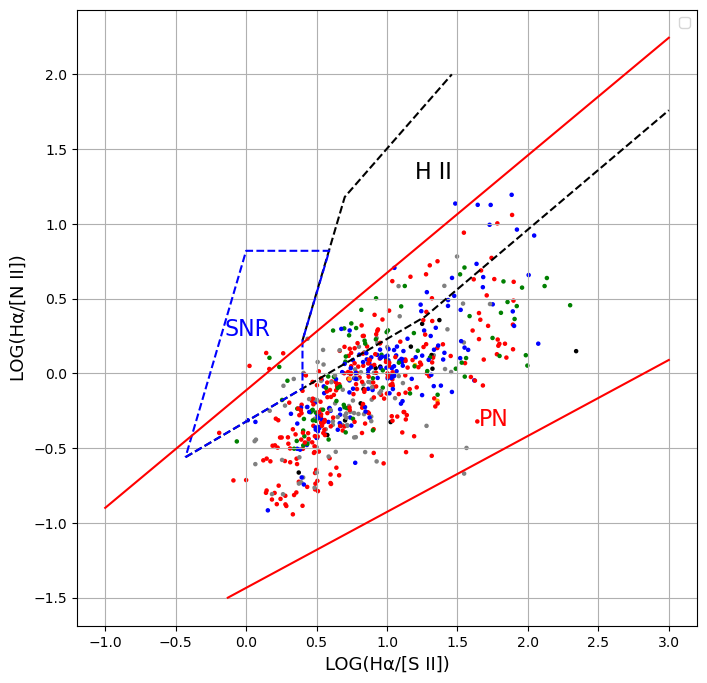

In [6]:
#######.     SMB     ######

import pandas as pd
import matplotlib.pyplot as plt

fontsize = 16
# Excel dosyasından verileri oku
excel_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/Sigma_5_renkli.xlsx'
data = pd.read_excel(excel_path, sheet_name='smb_bpt')

# Renk haritası oluştur
color_map = {
    'Bulge': 'blue',
    'Thin Disc': 'red',
    'Thick Disk': 'green',
    'Halo': 'orange',
    'no distance': 'grey',
    'no data': 'black'
}

# Veri noktaları için renkleri belirle
colors = data['Gbileşen'].map(color_map)

# Ekspresyon verileri
x_exp_HII = [-0.43, 1.27, 3]
y_exp_HII = [-0.56, 0.38, 1.76]

x2_exp_HII = [0.40, 0.70, 1.46]
y2_exp_HII = [0.22, 1.18, 2.00]

x_exp_SNR = [-0.43, 0.40, 0.40, 0.59, 0.00, -0.43]
y_exp_SNR = [-0.56, -0.10, 0.22, 0.82, 0.82, -0.56]

x_exp_PNe = [-0.13, 3]
y_exp_PNe = [-1.50, 0.09]

x2_exp_PNe = [-1.00, 3.00]
y2_exp_PNe = [-0.899, 2.245]

# Grafik çizimi
plt.figure(figsize=(8, 8))

# Her bir veri setini çizim
plt.plot(x_exp_HII, y_exp_HII, 'k--'#, label='H II'
        )
plt.plot(x2_exp_HII, y2_exp_HII, 'k--')

plt.plot(x_exp_SNR, y_exp_SNR, 'b--'#, label='SNR'
        )

plt.plot(x_exp_PNe, y_exp_PNe, 'r-'#, label='PNe'
        )
plt.plot(x2_exp_PNe, y2_exp_PNe, 'r-')

# Excel verilerini küçük kırmızı nokta olarak ekle
plt.scatter(data['LOG(HS2)'], data['LOG(HN2)'], c=colors, s=5#, label='True PN'
           )

# Eksen etiketleri ve başlık
plt.xlabel(('LOG(Hα/[S II])'), fontsize=13)
plt.ylabel(('LOG(Hα/[N II])'), fontsize=13)

# Bölge isimlerini ekle
plt.text(1.65, -0.35, "PN", {"size": fontsize, "color": "Red"})
plt.text(-0.15, 0.25, "SNR", {"size": fontsize, "color": "Blue"})
plt.text(1.2, 1.3, "H II", {"size": fontsize, "color": "Black"})

# Legend ekleme
plt.legend()

# Grid eklemek istiyorsanız kullanabilirsiniz.
plt.grid(True)

# Grafik dosyasını PNG olarak kaydetme
#plt.savefig('/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/deneme_SMB.png', bbox_inches='tight', dpi=300)

# Grafik gösterme
plt.show()

NameError: name 'np' is not defined

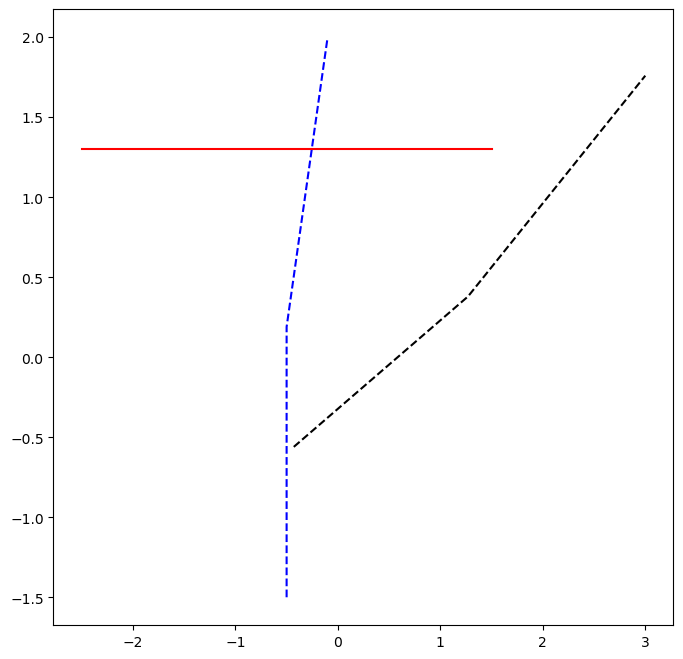

In [7]:
############ BTP a ##############

import pandas as pd
import matplotlib.pyplot as plt

fontsize = 16
# Excel dosyasından verileri oku
excel_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/Sigma_5_renkli.xlsx'
data = pd.read_excel(excel_path, sheet_name='smb_bpt')

# Veriler
x_exp_SNR = [-0.50, -0.50, -0.10]
y_exp_SNR = [-1.50, 0.19, 2.00]
e_exp_PNe = [-2.50, 1.50]
y_exp_PNe = [1.30, 1.30]

# Renk haritası oluştur
color_map = {
    'Bulge': 'blue',
    'Thin Disc': 'red',
    'Thick Disk': 'green',
    'Halo': 'orange',
    'no distance': 'grey',
    'no data': 'black'
}

# Veri noktaları için renkleri belirle
colors = data['Gbileşen'].map(color_map)

# Grafik çizimi
plt.figure(figsize=(8, 8))

plt.plot(x_exp_SNR, y_exp_SNR, 'b--', label='SNR')
plt.plot(e_exp_PNe, y_exp_PNe, 'r-', label='PNe')
plt.plot(x_exp_HII, y_exp_HII, 'k--', label='H II')

# Excel verilerini küçük kırmızı nokta olarak ekle

x_data = np.linspace(-2.5, 0.3, 1000)
y_data = (0.61 / (x_data - 0.47)) + 1
 
y_f = interp1d(x_data, y_data, 'cubic')
yf = y_f(x_data)
plt.plot(x_data, yf, 'k--')


plt.scatter(data['LOG(N2H)'], data['LOG(O3H2)'], c=colors, s=5)

# Eksen etiketleri ve başlık
plt.xlabel('LOG([S II])/Hα)', fontsize=13)
plt.ylabel('LOG([O III] 5007/Hβ)', fontsize=13)

# Bölge isimlerini ekle
plt.text(1.0, 0.8, "PN", {"size": fontsize, "color": "Red"})
plt.text(0.2, 0.10, "SNR", {"size": fontsize, "color": "Blue"})
plt.text(-1.5, 0.3, "H II", {"size": fontsize, "color": "Black"})

# Legend ekleme
plt.legend()

# Grid eklemek istiyorsanız kullanabilirsiniz.
plt.grid(True)

# Grafik dosyasını PNG olarak kaydetme
plt.savefig('/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/deneme_BPTa.png', bbox_inches='tight', dpi=300)

# Grafik gösterme
plt.show()


In [ ]:
######## BPTb ##############

from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fontsize = 16
# Excel dosyasından verileri oku
excel_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/Sigma_5_renkli.xlsx'
data = pd.read_excel(excel_path, sheet_name='smb_bpt')

# Veriler
x_exp_HII = [-0.40, -3]
y_exp_HII = [0.30, 0.99]

x_exp_SNR = [-0.40, -0.40, 0.09]
y_exp_SNR = [-1.49, 0.30, 1.99]

x_exp_PNe = [-4, -0.41, -0.16, -0.00, -0.00]
y_exp_PNe = [1.30, 1.30, 1.15, 0.90, 0.00]

# Renk haritası oluştur
color_map = {
    'Bulge': 'blue',
    'Thin Disc': 'red',
    'Thick Disk': 'green',
    'Halo': 'orange',
    'no distance': 'grey',
    'no data': 'black'
}

# Veri noktaları için renkleri belirle
colors = data['Gbileşen'].map(color_map)

# Grafik çizimi
plt.figure(figsize=(8, 8))

# Her bir veri setini çizim
plt.plot(x_exp_HII, y_exp_HII, 'k--', label='H II')
plt.plot(x_exp_SNR, y_exp_SNR, 'b--', label='SNR')
plt.plot(x_exp_PNe, y_exp_PNe, 'r-', label='PNe')

# Excel verilerini küçük nokta olarak ekle
x = data['LOG(S2H)']
y = data['LOG(O3H2)']

x_data = np.linspace(-4, 0.1, 100)
y_data = (0.72 / (x_data - 0.32)) + 1.30

y_f = interp1d(x_data, y_data, 'cubic')
yf = y_f(x_data)
plt.plot(x_data, yf, 'k--')
plt.scatter(data['LOG(S2H)'], data['LOG(O3H2)'], c=colors, s=5)

# Eksen etiketleri ve başlık
plt.xlabel('LOG([S II]/Hα)', fontsize=13)
plt.ylabel('LOG([O III] 5007/Hβ)', fontsize=13)

# Bölge isimlerini ekle
plt.text(-2.4, 1.0, "PN", {"size": fontsize, "color": "Red"})
plt.text(0.2, 0.10, "SNR", {"size": fontsize, "color": "Blue"})
plt.text(-1.5, 0.3, "H II", {"size": fontsize, "color": "Black"})

# Legend ekleme
plt.legend()

# Grid eklemek istiyorsanız kullanabilirsiniz.
plt.grid(True)

# Grafik dosyasını PNG olarak kaydetme
#plt.savefig('/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/deneme_BPTb.png', bbox_inches='tight', dpi=300)

# Grafik gösterme
plt.show()

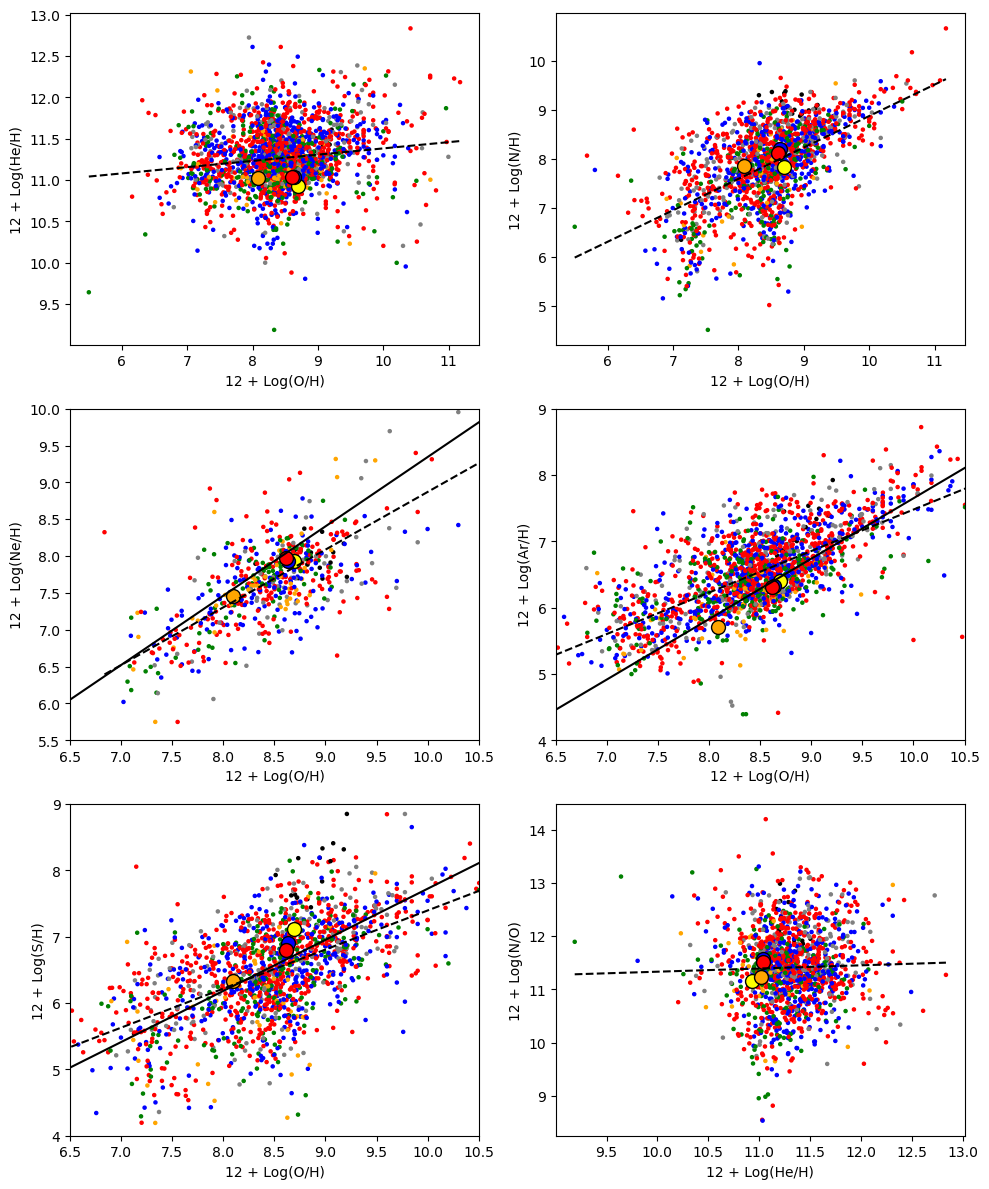

He vs O: y = (10.6264 ± 0.0181) + (0.0757 ± 0.0263)x, R^2 = 0.0202, n = 2135
N vs O: y = (2.4659 ± 0.0404) + (0.6410 ± 0.0549)x, R^2 = 0.3229, n = 1523
Ne vs O: y = (1.0464 ± 0.0467) + (0.7824 ± 0.0793)x, R^2 = 0.4775, n = 568
Ar vs O: y = (1.2339 ± 0.0246) + (0.6245 ± 0.0355)x, R^2 = 0.4787, n = 1797
S vs O: y = (1.5118 ± 0.0369) + (0.5884 ± 0.0508)x, R^2 = 0.3236, n = 1493
N/O vs He: y = (10.7338 ± 0.0445) + (0.0599 ± 0.1260)x, R^2 = 0.0009, n = 1405

Component-wise Trend Line Information:
He vs O (Bulge): y = (10.6108 ± 0.0340) + (0.0775 ± 0.0527)x, R^2 = 0.0188, n = 602
He vs O (Thin Disc): y = (10.5473 ± 0.0289) + (0.0878 ± 0.0392)x, R^2 = 0.0309, n = 840
He vs O (Thick Disk): y = (10.7048 ± 0.0446) + (0.0590 ± 0.0700)x, R^2 = 0.0106, n = 354
He vs O (Halo): y = (11.3507 ± 0.0737) + (-0.0256 ± 0.1222)x, R^2 = 0.0026, n = 92
He vs O (no distance): y = (10.9273 ± 0.0578) + (0.0471 ± 0.0782)x, R^2 = 0.0084, n = 228
He vs O (no data): y = (9.6445 ± 0.0909) + (0.1903 ± 0.3108)x, R^2 = 

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import linregress

# Excel dosyasını oku
dosya_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/total_abun.xlsx"
sayfa_adi = "Sayfa2"
data = pd.read_excel(dosya_yolu, sheet_name=sayfa_adi)

# Sütun başlıklarıyla birlikte verileri al
He_H = data["He/H"] + 12.0
N_H = data["N/H"] + 12.0
O_H = data["O/H"] + 12.0
Ne_H = data["Ne/H"] + 12.0
Ar_H = data["Ar/H"] + 12.0
S_H = data["S/H"] + 12.0

# Solar, disk, bulge ve halo değerleri
sol = [-1.07, -4.17, -3.31, -4.07, -5.6, -4.88]
disk = [-0.96, -3.87, -3.39, -4.03, -5.69, -5.20]
bulge = [-0.96, -3.80, -3.37, -4.07, -5.68, -5.09]
halo = [-0.98, -4.15, -3.91, -4.54, -6.29, -5.66]

# Renk haritası oluştur
color_map = {
    'Bulge': 'blue',
    'Thin Disc': 'red',
    'Thick Disk': 'green',
    'Halo': 'orange',
    'no distance': 'grey',
    'no data': 'black'
}

# Veri noktaları için renkleri belirle
colors = data['Gbileşen'].map(color_map)

# Trend çizgisi ve R^2 değerlerini kaydetmek için liste
trend_info = []
component_trend_info = []

# Trend çizgisi eklemek için yardımcı fonksiyon
def add_trend_line(ax, x_data, y_data, label):
    mask = np.isfinite(x_data) & np.isfinite(y_data)
    x_data_clean = x_data[mask]
    y_data_clean = y_data[mask]
    
    if len(x_data_clean) > 1:
        # Linear regression with standard error
        slope, intercept, r_value, p_value, std_err = linregress(x_data_clean, y_data_clean)
        
        x_values = np.linspace(min(x_data_clean), max(x_data_clean), 100)
        y_values = slope * x_values + intercept
        ax.plot(x_values, y_values, color='black', linestyle='--')
        
        # Calculate confidence intervals
        n = len(x_data_clean)
        t = 2.306  # 95% confidence interval for large sample sizes (df > 30)
        slope_ci = t * std_err
        intercept_ci = t * std_err * np.sqrt(np.sum((x_data_clean - np.mean(x_data_clean))**2) / n)
        
        trend_info.append(f"{label}: y = ({intercept:.4f} ± {intercept_ci:.4f}) + ({slope:.4f} ± {slope_ci:.4f})x, R^2 = {r_value**2:.4f}, n = {n}")

# Her bileşen için trend çizgisi hesaplamak için yardımcı fonksiyon
def calculate_component_trend(x_data, y_data, component, label):
    mask = (data['Gbileşen'] == component) & np.isfinite(x_data) & np.isfinite(y_data)
    x_data_clean = x_data[mask]
    y_data_clean = y_data[mask]
    
    if len(x_data_clean) > 1:
        # Linear regression with standard error
        slope, intercept, r_value, p_value, std_err = linregress(x_data_clean, y_data_clean)
        
        # Calculate confidence intervals
        n = len(x_data_clean)
        t = 2.306  # 95% confidence interval for large sample sizes (df > 30)
        slope_ci = t * std_err
        intercept_ci = t * std_err * np.sqrt(np.sum((x_data_clean - np.mean(x_data_clean))**2) / n)
        
        component_trend_info.append(f"{label} ({component}): y = ({intercept:.4f} ± {intercept_ci:.4f}) + ({slope:.4f} ± {slope_ci:.4f})x, R^2 = {r_value**2:.4f}, n = {n}")

# Grafik oluştur
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

#####################     He     #####################
axs[0, 0].scatter(O_H, He_H, color=colors, s=5)
axs[0, 0].set_xlabel('12 + Log(O/H)')
axs[0, 0].set_ylabel('12 + Log(He/H)')
axs[0, 0].scatter(sol[2] + 12.0, sol[0] + 12.0, color='yellow', edgecolors='black', linewidths=1, s=100)
axs[0, 0].scatter(bulge[2] + 12.0, bulge[0] + 12.0, color='blue', edgecolors='black', linewidths=1, s=100)
axs[0, 0].scatter(disk[2] + 12.0, disk[0] + 12.0, color='red', edgecolors='black', linewidths=1, s=100)
axs[0, 0].scatter(halo[2] + 12.0, halo[0] + 12.0, color='orange', edgecolors='black', linewidths=1, s=100)
add_trend_line(axs[0, 0], O_H, He_H, 'He vs O')
for component in color_map.keys():
    calculate_component_trend(O_H, He_H, component, 'He vs O')

#####################     N     #####################
axs[0, 1].scatter(O_H, N_H, color=colors, s=5)
axs[0, 1].set_xlabel('12 + Log(O/H)')
axs[0, 1].set_ylabel('12 + Log(N/H)')
axs[0, 1].scatter(sol[2] + 12.0, sol[1] + 12.0, color='yellow', edgecolors='black', linewidths=1, s=100)
axs[0, 1].scatter(bulge[2] + 12.0, bulge[1] + 12.0, color='blue', edgecolors='black', linewidths=1, s=100)
axs[0, 1].scatter(disk[2] + 12.0, disk[1] + 12.0, color='red', edgecolors='black', linewidths=1, s=100)
axs[0, 1].scatter(halo[2] + 12.0, halo[1] + 12.0, color='orange', edgecolors='black', linewidths=1, s=100)
add_trend_line(axs[0, 1], O_H, N_H, 'N vs O')
for component in color_map.keys():
    calculate_component_trend(O_H, N_H, component, 'N vs O')

#####################     Ne     #####################
m = 0.94
b = -0.056
x_values = np.linspace(6.5, 10.5, 100)
y_values = m * x_values + b
axs[1, 0].plot(x_values, y_values, color='black', linestyle='solid')
axs[1, 0].scatter(O_H, Ne_H, color=colors, s=5)
axs[1, 0].set_xlabel('12 + Log(O/H)')
axs[1, 0].set_ylabel('12 + Log(Ne/H)')
axs[1, 0].set_ylim(5.5, 10.0)
axs[1, 0].set_xlim(6.5, 10.5)
axs[1, 0].scatter(sol[2] + 12.0, sol[3] + 12.0, color='yellow', edgecolors='black', linewidths=1, s=100)
axs[1, 0].scatter(bulge[2] + 12.0, bulge[3] + 12.0, color='blue', edgecolors='black', linewidths=1, s=100)
axs[1, 0].scatter(disk[2] + 12.0, disk[3] + 12.0, color='red', edgecolors='black', linewidths=1, s=100)
axs[1, 0].scatter(halo[2] + 12.0, halo[3] + 12.0, color='orange', edgecolors='black', linewidths=1, s=100)
add_trend_line(axs[1, 0], O_H, Ne_H, 'Ne vs O')
for component in color_map.keys():
    calculate_component_trend(O_H, Ne_H, component, 'Ne vs O')

#####################     Ar     #####################
m = 0.91
b = -1.45
x_values = np.linspace(6.5, 10.5, 100)
y_values = m * x_values + b
axs[1, 1].plot(x_values, y_values, color='black', linestyle='solid')
axs[1, 1].scatter(O_H, Ar_H, color=colors, s=5)
axs[1, 1].set_xlabel('12 + Log(O/H)')
axs[1, 1].set_ylabel('12 + Log(Ar/H)')
axs[1, 1].set_ylim(4, 9.0)
axs[1, 1].set_xlim(6.5, 10.5)
axs[1, 1].scatter(sol[2] + 12.0, sol[4] + 12.0, color='yellow', edgecolors='black', linewidths=1, s=100)
axs[1, 1].scatter(bulge[2] + 12.0, bulge[4] + 12.0, color='blue', edgecolors='black', linewidths=1, s=100)
axs[1, 1].scatter(disk[2] + 12.0, disk[4] + 12.0, color='red', edgecolors='black', linewidths=1, s=100)
axs[1, 1].scatter(halo[2] + 12.0, halo[4] + 12.0, color='orange', edgecolors='black', linewidths=1, s=100)
add_trend_line(axs[1, 1], O_H, Ar_H, 'Ar vs O')
for component in color_map.keys():
    calculate_component_trend(O_H, Ar_H, component, 'Ar vs O')

#####################     S     #####################
m = 0.77
b = 0.024
x_values = np.linspace(6.5, 10.5, 100)
y_values = m * x_values + b
axs[2, 0].plot(x_values, y_values, color='black', linestyle='solid')
axs[2, 0].scatter(O_H, S_H, color=colors, s=5)
axs[2, 0].set_xlabel('12 + Log(O/H)')
axs[2, 0].set_ylabel('12 + Log(S/H)')
axs[2, 0].set_ylim(4, 9.0)
axs[2, 0].set_xlim(6.5, 10.5)
axs[2, 0].scatter(sol[2] + 12.0, sol[5] + 12.0, color='yellow', edgecolors='black', linewidths=1, s=100)
axs[2, 0].scatter(bulge[2] + 12.0, bulge[5] + 12.0, color='blue', edgecolors='black', linewidths=1, s=100)
axs[2, 0].scatter(disk[2] + 12.0, disk[5] + 12.0, color='red', edgecolors='black', linewidths=1, s=100)
axs[2, 0].scatter(halo[2] + 12.0, halo[5] + 12.0, color='orange', edgecolors='black', linewidths=1, s=100)
add_trend_line(axs[2, 0], O_H, S_H, 'S vs O')
for component in color_map.keys():
    calculate_component_trend(O_H, S_H, component, 'S vs O')

#####################     NO     #####################     
N_O = pd.Series([N_H_val - O_H_val + 12.0 for N_H_val, O_H_val in zip(N_H, O_H)])
axs[2, 1].scatter(He_H, N_O, color=colors, s=5)
axs[2, 1].set_xlabel('12 + Log(He/H)')
axs[2, 1].set_ylabel('12 + Log(N/O)')
axs[2, 1].scatter(10.93, 12.0 - 0.85, color='yellow', edgecolors='black', linewidths=1, s=100)
axs[2, 1].scatter(bulge[0] + 12.0, 12.0 + bulge[1] - bulge[2], color='blue', edgecolors='black', linewidths=1, s=100)
axs[2, 1].scatter(disk[0] + 12.0, 12.0 + disk[1] - disk[2], color='red', edgecolors='black', linewidths=1, s=100)
axs[2, 1].scatter(halo[0] + 12.0, 12.0 + halo[1] - disk[2], color='orange', edgecolors='black', linewidths=1, s=100)
add_trend_line(axs[2, 1], He_H, N_O, 'N/O vs He')
for component in color_map.keys():
    calculate_component_trend(He_H, N_O, component, 'N/O vs He')

# Grafik ayarları
plt.tight_layout()
#plt.savefig('/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/abun_deneme.pdf')   # save the figure to file
plt.show()

# Trend çizgisi bilgilerini yazdır
for info in trend_info:
    print(info)

print("\nComponent-wise Trend Line Information:")
for info in component_trend_info:
    print(info)

Y ekseninde kullanılacak sütun adını girin: Ar/H
X ekseninde kullanılacak sütun adını girin: O/H


/Users/nurullah/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nurullah/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/ry/6rcrw5vs4f33lx3wyt4f6m5w0000gn/T/ipykernel_57639/724907485.py:65: RuntimeWarning: invalid value encountered in log10
  sol_log = 12 + np.log10(sol)
/var/folders/ry/6rcrw5vs4f33lx3wyt4f6m5w0000gn/T/ipykernel_57639/724907485.py:66: RuntimeWarning: invalid value encountered in log10
  disk_log = 12 + np.log10(disk)
/var/folders/ry/6rcrw5vs4f33lx3wyt4f6m5w0000gn/T/ipykernel_57639/724907485.py:67: RuntimeWarning: invalid value encountered in log10
  bulge_log = 12 + np.log10(bulge)
/var/folders/ry/6rcrw5vs4f33lx3wyt4f6m5w0000gn/T/ipykernel_57639/724907485.py:68: RuntimeWarning: invalid value encountere

Grafik başarıyla kaydedildi: /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/görüntüler/ArH_OH.png


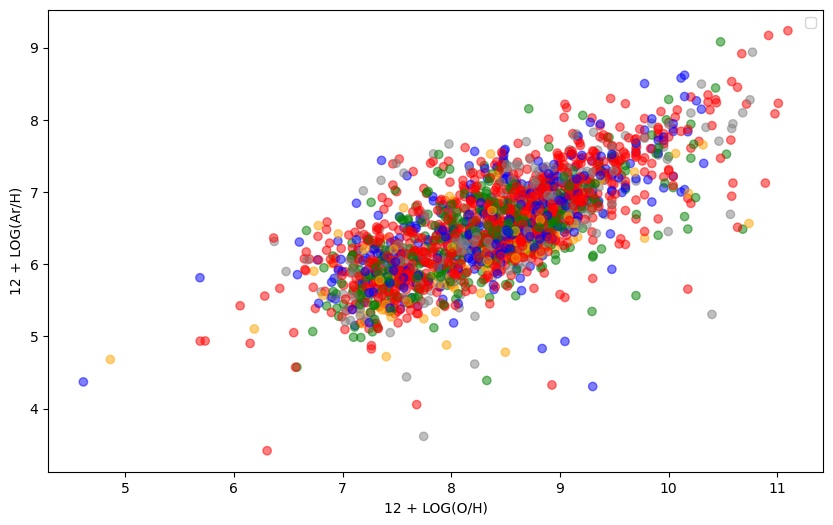

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Excel dosyasını oku
dosya_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/08122023_output.xlsx"
sayfa_adi = "neat_results"
veri = pd.read_excel(dosya_yolu, sheet_name=sayfa_adi)

# Renklendirilmiş veriyi oku
renklendirilmis_df = pd.read_excel(dosya_yolu, sheet_name='Sayfa11')

# Hangi sütunlarda işlem yapacağınızı belirtin
y_sutunu = input("Y ekseninde kullanılacak sütun adını girin: ")
x_sutunu = input("X ekseninde kullanılacak sütun adını girin: ")

# İşlemi yapın ve yeni sütunları oluşturun
veri['X'] = 12 + np.log10(veri[x_sutunu])
veri['Y'] = 12 + np.log10(veri[y_sutunu])

# Renklendirme fonksiyonu
def get_color(component):
    if component == 'Bulge':
        return 'blue'
    elif component == 'Thin Disc':
        return 'red'
    elif component == 'Thick Disk':
        return 'green'
    elif component == 'Halo':
        return 'orange'
    elif component == 'no distance':
        return 'gray'
    else:
        return 'black'

# Renklendirme bilgilerini ekle
renklendirilmis_df['color'] = renklendirilmis_df['Gbileşen'].apply(get_color)
renk_dict = renklendirilmis_df.set_index('idPNMain')['color'].to_dict()

# Renklere karşılık gelen etiketler
renk_etiketleri = {
    'red': 'Thin Disc',
    'green': 'Thick Disc',
    'blue': 'Bulge',
    'orange': 'Halo',
    'gray': 'No Distance',
    'black': 'Unknown'
}

# Grafik çizimi
plt.figure(figsize=(10, 6))

# Veri noktalarını renklendir
colors = veri['idPNMain'].map(renk_dict)
plt.scatter(veri['X'], veri['Y'], c=colors, alpha=0.5)

# Ekstra değerler
sol = [-4.17]
disk = [-3.87]
bulge = [-3.80]
halo = [-4.15]

# 12 + log10 hesaplamaları
sol_log = 12 + np.log10(sol)
disk_log = 12 + np.log10(disk)
bulge_log = 12 + np.log10(bulge)
halo_log = 12 + np.log10(halo)

# Her grubu farklı renkte ve siyah kenarlıklı eklemek
plt.scatter(sol_log, sol_log, color='yellow', edgecolors='black', linewidths=1, zorder=3, s=100)
plt.scatter(disk_log, disk_log, color='red', edgecolors='black', linewidths=1,  zorder=3, s=100)
plt.scatter(bulge_log, bulge_log, color='blue', edgecolors='black', linewidths=1, zorder=3, s=100)
plt.scatter(halo_log, halo_log, color='orange', edgecolors='black', linewidths=1, zorder=3, s=100)

plt.xlabel(f'12 + LOG({x_sutunu})')
plt.ylabel(f'12 + LOG({y_sutunu})')
plt.legend()

# Grafiği kaydetme
kayit_klasoru = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/görüntüler/"
kayit_adi = "ArH_OH.png"  # İstediğiniz dosya adı
kayit_yolu = os.path.join(kayit_klasoru, kayit_adi)

# Ensure the directory exists
if not os.path.exists(kayit_klasoru):
    os.makedirs(kayit_klasoru)

plt.savefig(kayit_yolu)

# Output file path confirmation
if os.path.exists(kayit_yolu):
    print(f"Grafik başarıyla kaydedildi: {kayit_yolu}")
else:
    print("Grafik kaydedilemedi.")

# Grafiği gösterme
plt.show()


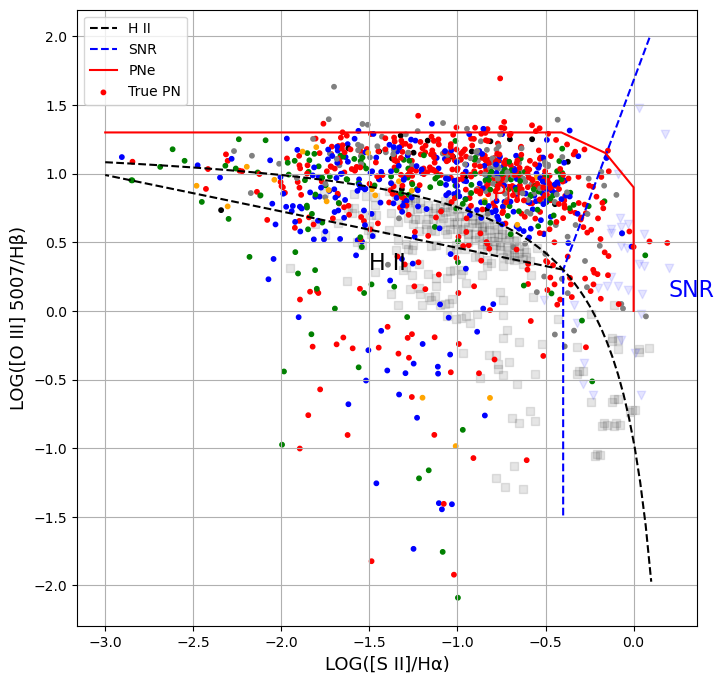

In [18]:
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fontsize = 16
# Excel dosyasından verileri oku
excel_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/Sigma_5_renkli.xlsx'
data = pd.read_excel(excel_path, sheet_name='smb_bpt')


# Renk haritası oluştur
color_map = {
    'Bulge': 'blue',
    'Thin Disc': 'red',
    'Thick Disk': 'green',
    'Halo': 'orange',
    'no distance': 'grey',
    'no data': 'black'
}

# Veri noktaları için renkleri belirle
colors = data['Gbileşen'].map(color_map)

# Grafik çizimi
plt.figure(figsize=(8, 8))

# Her bir veri setini çizim
# Veriler
data1 = pd.read_excel('/Users/nurullah/python_kodlar/BPT_b_HII_regions.xlsx')
 
x1 = data1['LOG1']
y1 = data1['LOG2']
 
plt.scatter(x1, y1, c='black', marker='s', alpha=0.1)
 
data2 = pd.read_csv('/Users/nurullah/python_kodlar/BPT_b_SNR.csv', sep='\t')
 
x2 = data2['LOG1']
y2 = data2['LOG2']
 
plt.scatter(x2, y2, c='blue', marker='v', alpha=0.1)
 
x_exp_HII = [-0.40, -3]
y_exp_HII = [0.30, 0.99]
x_exp_SNR = [-0.40, -0.40, 0.09]
y_exp_SNR = [-1.49, 0.30, 1.99]
x_exp_PNe = [-3, -0.41, -0.16, -0.00, -0.00]
y_exp_PNe = [1.30, 1.30, 1.15, 0.90, 0.00]

plt.plot(x_exp_HII, y_exp_HII, 'k--', label='H II')
plt.plot(x_exp_SNR, y_exp_SNR, 'b--', label='SNR')
plt.plot(x_exp_PNe, y_exp_PNe, 'r-', label='PNe')

# Excel verilerini küçük nokta olarak ekle
x = data['LOG(S2H)']
y = data['LOG(O3H2)']

x_data = np.linspace(-3, 0.1, 100)
y_data = (0.72 / (x_data - 0.32)) + 1.30

y_f = interp1d(x_data, y_data, 'cubic')
yf = y_f(x_data)
plt.scatter(data['LOG(S2H)'], data['LOG(O3H2)'], c=colors, s=10, label='True PN')

# Plot the curve
plt.plot(x_data, yf, 'k--')
# Eksen etiketleri ve başlık
plt.xlabel('LOG([S II]/Hα)', fontsize=13)
plt.ylabel('LOG([O III] 5007/Hβ)', fontsize=13)

# Bölge isimlerini ekle
plt.text(-0.8, 0.8, "PN", {"size": fontsize, "color": "Red"})
plt.text(0.2, 0.10, "SNR", {"size": fontsize, "color": "Blue"})
plt.text(-1.5, 0.3, "H II", {"size": fontsize, "color": "Black"})

# Legend ekleme
plt.legend()

# Grid eklemek istiyorsanız kullanabilirsiniz.
plt.grid(True)

# Grafik dosyasını PNG olarak kaydetme
#plt.savefig('/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/deneme_BPTb.png', bbox_inches='tight', dpi=300)

# Grafik gösterme
plt.show()

In [ ]:
####### makaletablo2 ####### neat çıktılarından hdul1den verileri alırken hata hesabını yaparak excel 
#dosyalarına kaydedip. daha sonraki kodda tek bir excel dosyasında birleştirmek. 3. kodda ise tablo oluşturduğumuz 
#değerleri seçerek yeni bir excel dosyası seçmek

from astropy.io import fits
import pandas as pd
import os

# Dizin içindeki tüm FITS dosyalarını al
fits_directory = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/neat_out/'
fits_file_paths = [os.path.join(fits_directory, file) for file in sorted(os.listdir(fits_directory)) if file.endswith('.fits')]

# Excel dosyalarının kaydedileceği dizin
output_directory = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/neat_to_excel/deneme/'
os.makedirs(output_directory, exist_ok=True)

# Her 50 FITS dosyası için ayrı bir Excel dosyası oluştur
batch_size = 50

# Dosya isimlerini saklayacak bir sözlük oluştur
file_names_dict = {}

for i in range(0, len(fits_file_paths), batch_size):
    batch_fits_files = fits_file_paths[i:i + batch_size]

    # Excel dosyasının ismini belirle
    excel_file_name = f'batch_{i // batch_size + 1}.xlsx'
    excel_file_path = os.path.join(output_directory, excel_file_name)

    # Her FITS dosyası için döngü
    with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
        for fits_file_path in batch_fits_files:
            # Open the FITS file
            with fits.open(fits_file_path) as hdul:
                # Access the data and header of the LINES BinTableHDU (hdul[2])
                data = hdul[1].data

                # Convert the FITS data to a pandas DataFrame
                df = pd.DataFrame(data)

                # Sadece belirtilen sütunları seç
                selected_columns = ['WlenRest', 'Flux', 'Uncertainty', 'Ion', 'DereddenedFlux', 'DereddenedFluxLo', 'DereddenedFluxHi']
                df_selected = df[selected_columns]

                # Negatif ve sıfıra eşit olan değerlere sahip satırları filtrele ve sil
                df_selected = df_selected[df_selected['Flux'] > 0.01]

                # Yeni sütunu ekle
                df_selected['AdjustedFlux'] = ((df_selected['DereddenedFluxLo'] - df_selected['DereddenedFlux']) + (df_selected['DereddenedFlux'] - df_selected['DereddenedFluxHi'])) / 2

                # Sadece gerekli sütunları seç
                final_columns = ['WlenRest', 'Flux', 'Uncertainty', 'Ion', 'DereddenedFlux', 'AdjustedFlux']
                df_final = df_selected[final_columns]

                # Sayfa adını dosya isminin ilk 31 karakteri olarak ayarla
                sheet_name = os.path.basename(fits_file_path)[:31]
                
                # Tam dosya ismini sözlüğe ekle
                file_names_dict[sheet_name] = os.path.basename(fits_file_path)

                # Verileri içeren DataFrame'i yeni bir sayfada kaydet
                df_final.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"Data has been successfully exported to {excel_file_path}")

# Dosya isimlerini bir CSV dosyasına kaydedelim
file_names_dict_path = os.path.join(output_directory, 'file_names_dict.csv')
file_names_df = pd.DataFrame(list(file_names_dict.items()), columns=['SheetName', 'FullFileName'])
file_names_df.to_csv(file_names_dict_path, index=False)


In [ ]:
import pandas as pd
import os

# Excel dosyalarının bulunduğu klasörün tam yolu
excel_folder_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/neat_to_excel/deneme/'

# Tüm Excel dosyalarını al
excel_files = [os.path.join(excel_folder_path, file) for file in sorted(os.listdir(excel_folder_path)) if file.endswith('.xlsx')]

# Dosya isimleri sözlüğünü oku
file_names_dict_path = os.path.join(excel_folder_path, 'file_names_dict.csv')
file_names_df = pd.read_csv(file_names_dict_path)
file_names_dict = dict(zip(file_names_df['SheetName'], file_names_df['FullFileName']))

# Birleştirilecek verileri tutacak ana DataFrame'i oluştur
main_df = pd.DataFrame()

# Her Excel dosyası için döngü
for excel_file_path in excel_files:
    # Excel dosyasını oku
    df = pd.read_excel(excel_file_path, sheet_name=None)

    # Her sayfa için döngü
    for sheet_name, sheet_data in df.items():
        # 'WlenRest', 'Ion', 'DereddenedFlux', 'AdjustedFlux' sütunlarını içeren sayfaları seç
        if all(col in sheet_data.columns for col in ['WlenRest', 'Ion', 'DereddenedFlux', 'AdjustedFlux']):
            full_file_name = file_names_dict.get(sheet_name, sheet_name)
            # Eğer ana DataFrame boşsa, direkt ekle
            if main_df.empty:
                main_df = sheet_data[['WlenRest', 'Ion', 'DereddenedFlux', 'AdjustedFlux']].copy()
                main_df.rename(columns={
                    'DereddenedFlux': f'DereddenedFlux_{full_file_name}',
                    'AdjustedFlux': f'AdjustedFlux_{full_file_name}'
                }, inplace=True)
            else:
                # Ana DataFrame'de 'WlenRest' ve 'Ion' sütunlarına göre birleştirme yap
                main_df = main_df.merge(
                    sheet_data[['WlenRest', 'Ion', 'DereddenedFlux', 'AdjustedFlux']],
                    on=['WlenRest', 'Ion'],
                    how='outer',
                    suffixes=('', f'_{full_file_name}')
                )
                main_df.rename(columns={
                    'DereddenedFlux': f'DereddenedFlux_{full_file_name}',
                    'AdjustedFlux': f'AdjustedFlux_{full_file_name}'
                }, inplace=True)

# NaN değerleri '-' ile değiştir
main_df.fillna('-', inplace=True)

# 'WlenRest' sütununa göre küçükten büyüğe sırala
main_df.sort_values('WlenRest', inplace=True)

# Excel dosyasına ekleyeceğimiz sayfa adı
new_sheet_name = 'DereddenedAdjustedFlux_Tablo'

# Yeni bir Excel dosyası oluştur
output_excel_file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/neat_to_excel/deneme/DereddenedErrorFlux_tablo.xlsx'
with pd.ExcelWriter(output_excel_file_path, engine='openpyxl') as writer:
    main_df.to_excel(writer, sheet_name=new_sheet_name, index=False)

print(f"Merged, sorted data has been successfully added to the sheet {new_sheet_name} in the Excel file.")


In [ ]:
#### satırda akılar,  sütunlarda ise tayf bilgileri var


import pandas as pd

# Merged Excel dosyasının tam yolu
merged_excel_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/neat_to_excel/deneme/DereddenedErrorFlux_tablo.xlsx'

# Filtrelenecek WlenRest değerleri
wlenrest_values = [
    3726.039, 3728.82, 4089.29, 4101.74, 4340.47, 4363.20, 4471.50,
    4649.12, 4661.62, 4711.37, 4740.16, 4958.91, 5006.83, 5191.81,
    5517.66, 5537.60, 5577.33, 5754.60, 5875.66, 6300.33, 6363.77,
    6548.10, 6562.77, 6583.50, 6678.16, 6716.43, 6730.81, 7005.66,
    7135.79, 7281.35, 7751.06
]


# Merged Excel dosyasını oku
main_df = pd.read_excel(merged_excel_path, sheet_name='Dflux_Error')

# Sadece belirli WlenRest değerlerine sahip olan satırları seç
filtered_df = main_df[main_df['WlenRest'].isin(wlenrest_values)]

# Yeni bir Excel dosyası oluştur
filtered_excel_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/Makale_DereddenedErrorFlux_Tablo.xlsx'
with pd.ExcelWriter(filtered_excel_path, engine='openpyxl') as writer:
    filtered_df.to_excel(writer, sheet_name='Filtered_DereddenedFlux_Tablo', index=False)

print(f"Filtered data has been successfully added to the new Excel file at {filtered_excel_path}.")

In [ ]:
#### satırda tayf bilgileri sütunlarda ise akı ve hataları var

import os
import pandas as pd
from astropy.io import fits

# Wavelength values to search for, formatted to 7 characters
wlenrest_values = [
    3726.03, 3728.82, 4089.29, 4101.74, 4340.47, 4363.21, 4471.50,
    4649.13, 4661.63, 4711.37, 4740.17, 4958.91, 5006.84, 5191.82,
    5517.66, 5537.60, 5577.34, 5754.60, 5875.66, 6300.34, 6363.78,
    6548.10, 6562.77, 6583.50, 6678.16, 6716.44, 6730.82, 7005.67,
    7135.80, 7281.35, 7751.06
]

# Convert wavelength values to 7-character strings
wlenrest_strings = [f"{wlenrest:.2f}".rjust(7, '0') for wlenrest in wlenrest_values]

# Data list to store the results
data_list = []

# Iterate over each FITS file
for fits_file in fits_files:
    file_path = os.path.join(fits_folder_path, fits_file)
    
    # Open the FITS file
    with fits.open(file_path) as hdul:
        # Get the data from the table (hdul[1])
        data = hdul[1].data
        
        # Prepare a list to store data for the current FITS file
        fits_data = [fits_file]  # First column: FITS file name
        
        for wlenrest_string in wlenrest_strings:
            matching_row = None
            for row in data:
                # Compare the first 7 characters of the second column's value
                if f"{row[1]:.2f}".rjust(7, '0') == wlenrest_string:
                    matching_row = row
                    break
            
            if matching_row is not None:
                # Add the last three column values
                fits_data.extend(matching_row[-6:-3])
            else:
                # Add empty values if wavelength is not found
                fits_data.extend(['-', '-', '-'])
        
        # Append the data for the current FITS file to the list
        data_list.append(fits_data)

# Create column names for the DataFrame
columns = ['FITS File'] + [f'{wlenrest_string}_Col_{i+1}' for wlenrest_string in wlenrest_strings for i in range(3)]

# Create the DataFrame
df = pd.DataFrame(data_list, columns=columns)

# Save the DataFrame to an Excel file
output_file = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/neat_to_excel/deneme/DereddenedFlux.xlsx'
df.to_excel(output_file, index=False)

print(f"Veriler '{output_file}' dosyasına kaydedildi.")

In [ ]:
#### fits result verilerinden ilgili satırdaki Te ve Ne değerlerini excele hatalarıyla beraber kaydediyor


import os
import pandas as pd
from astropy.io import fits

# FITS dosyalarının bulunduğu klasör yolu
fits_folder_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/neat_out/'

# Dosya isimlerini al
fits_files = [file for file in os.listdir(fits_folder_path) if file.endswith('.fits')]

# Belirli satır indeksleri
row_indices = [0, 4, 6, 9, 11, 13, 15, 20, 22, 35, 41, 45, 53, 62, 64, 66]

# Veri saklama listesi
data_list = []

# Her FITS dosyası için belirli satırlardaki değerleri al
for fits_file in fits_files:
    file_path = os.path.join(fits_folder_path, fits_file)
    
    # FITS dosyasını aç
    with fits.open(file_path) as hdul:
        # Verilerin bulunduğu tabloyu al (genellikle 'PRIMARY' veya 'TABLE')
        data = hdul[2].data
        
        # Verileri al ve listeye ekle
        row_data = [fits_file]  # İlk sütun: dosya ismi
        for idx in row_indices:
            if idx == 0:
                row = data[idx]
                row_data.extend(row[1:])  # 0. satırı doğrudan ekle
            else:
                row = data[idx]
                # İkinci sütundaki değerin 1'den büyük olduğunu ve üçüncü veya dördüncü sütundaki değerlerin 0'dan büyük olmadığını kontrol et
                if row[1] > 1 and row[2] <= 0 and row[3] <= 0:
                    row_data.extend(row[1:])
        
        # Boş satırlar eklenmemesi için kontrol et
        if len(row_data) > 1:
            data_list.append(row_data)

# Kolon isimlerini oluştur
columns = ['FITS File'] + [f'Satır {i} Kolon {j}' for i in row_indices for j in range(1, 4)]

# DataFrame oluştur
df = pd.DataFrame(data_list, columns=columns)

# Excel dosyasına kaydet
output_file = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/neat_to_excel/deneme/te_ne_data.xlsx'
df.to_excel(output_file, index=False)

print(f"Veriler '{output_file}' dosyasına kaydedildi.")
